# Evaluate Source Mappings


Prepare the dataset. Here, the default Beamformer used to generate the sourcemap feature is changed to CLEAN-SC to obtain
reasonable integration results.


In [32]:
import os
import tensorflow as tf 
import numpy as np
from acoular import BeamformerCleansc, L_p
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # change tensorflow log level for doc purposes

from acoupipe.datasets.dataset2 import DEFAULT_BEAMFORMER, Dataset2

beamformer = BeamformerCleansc(freq_data=DEFAULT_BEAMFORMER.freq_data)

# dataset
dataset = Dataset2(max_nsources=4, min_nsources=4, f=1000, beamformer=beamformer, features=["sourcemap"])     

# get one sample
data = next(dataset.generate(split="training", size=1, startsample=5))

sourcemap = data["sourcemap"]
loc_ref = data["loc"]
p2_ref = data["p2"]


  0%|          | 0/1 [00:00<?, ?it/s]


Now use the SourceMapEvaluator class to evaluate different metrics.

In [33]:
from acoupipe.evaluate import SourceMapEvaluator
from acoupipe.datasets.dataset2 import DEFAULT_GRID

src_auto_pow = np.diag(p2_ref[0,:,:,0])

# prepare to calculate metrics
se = SourceMapEvaluator(sourcemap=sourcemap, grid=DEFAULT_GRID, 
                                target_loc=loc_ref[:2], target_pow=src_auto_pow[np.newaxis], r=0.1,
                                variable_sector_radii=True)

specific_level_error = se.get_specific_level_error()[0] # for the first frequency
inverse_level_error = se.get_inverse_level_error()[0] # for the first frequency
overall_level_error = se.get_overall_level_error()[0] # for the first frequency


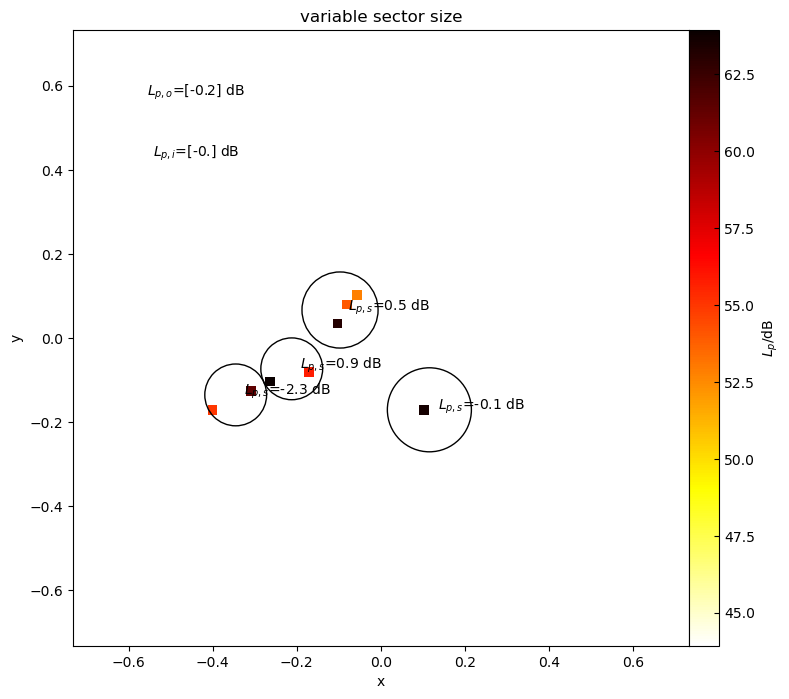

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Lm = L_p(sourcemap[0,...,0])

fig = plt.figure(1,(8,8))
# subplot results
ax = fig.add_subplot(111)
ax.set_title("variable sector size")
im = ax.imshow(Lm.T,vmax=Lm.max(),vmin=Lm.max()-20,cmap="hot_r",extent=DEFAULT_GRID.extend(),origin="lower")
#plot true positions
for j in range(loc_ref.shape[-1]):
    l = loc_ref[:,j]
    ax.add_patch(plt.Circle((l[0], l[1]), se.sector_radii[j], color="black",fill=False))
    ax.annotate(xycoords="data",xy=(l[0],l[0]),xytext=(l[0]+0.02,l[1]),text=r"$L_{p,s}$="+f"{np.round(specific_level_error[j],1)} dB")
ax.text(0.2, 0.9,r"$L_{p,o}$="+f"{np.round(overall_level_error[0],1)} dB",horizontalalignment="center", verticalalignment="center", transform = ax.transAxes)
ax.text(0.2, 0.8,r"$L_{p,i}$="+f"{np.round(inverse_level_error[0],1)} dB",horizontalalignment="center", verticalalignment="center", transform = ax.transAxes)
ax.set_xlabel("x")
ax.set_ylabel("y")
divider = make_axes_locatable(ax)
cax = divider.append_axes(
    position="right", 
    size="5%", 
    pad=0.0,)
cax.tick_params(direction="in")
fig.colorbar(im,cax,label=r"$L_{p}$/dB")
plt.tight_layout()
plt.show()